# FCNs for semantic segmentation

In this exercise we will look at the basics how to build a fully convolutional network for semantic segmentation.

## A first example

In [30]:
# install all needed packages
from typing import Tuple
import numpy as np
import skimage
import skimage.data
import skimage.io
import tensorflow.keras as keras
import matplotlib


# for displaying images in jupyter
from matplotlib import pyplot as plt

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 10]
#mpl.rcParams['figure.dpi']= 400

In [2]:
# check tensorflow installation to see if we have GPU support
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
print(keras.__version__)
import tensorflow
print(tensorflow.__version__)

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17034098759810633723
xla_global_id: -1
]
2.11.0
2.11.0


### Images for smoke tests

When building a new network, it is a good idea to check if the network works at all, as it can sometimes take a while until all the parameters are fixed. For that we generate some function to create some simple test images that we can use.

In [3]:
def gen_random_binary_test_image(height: int, width: int)->(np.ndarray, np.ndarray):
    """
    Generate a test image and an appropriate label image with label 0 or label 1
    Label 0 images have a lower medium grayscale value, label 1 images a higher one.
    
    The returned images will have shape (height, width, 1) and type uint8 to be as compatible as possible to 
    mages read from files
    """
    VALUE = [100.0, 200.0]
    CLASS_ID = [0, 1]
    NOISE = 20.0
    
    label = np.zeros((height, width, 1), dtype=np.uint8)
    class_id = np.random.choice(CLASS_ID)
    label.fill(class_id)
    img = np.random.normal(VALUE[class_id], NOISE, ((height, width, 1))).astype(np.uint8)
    
    return img, label

mean: 198.715576171875
mask: 1


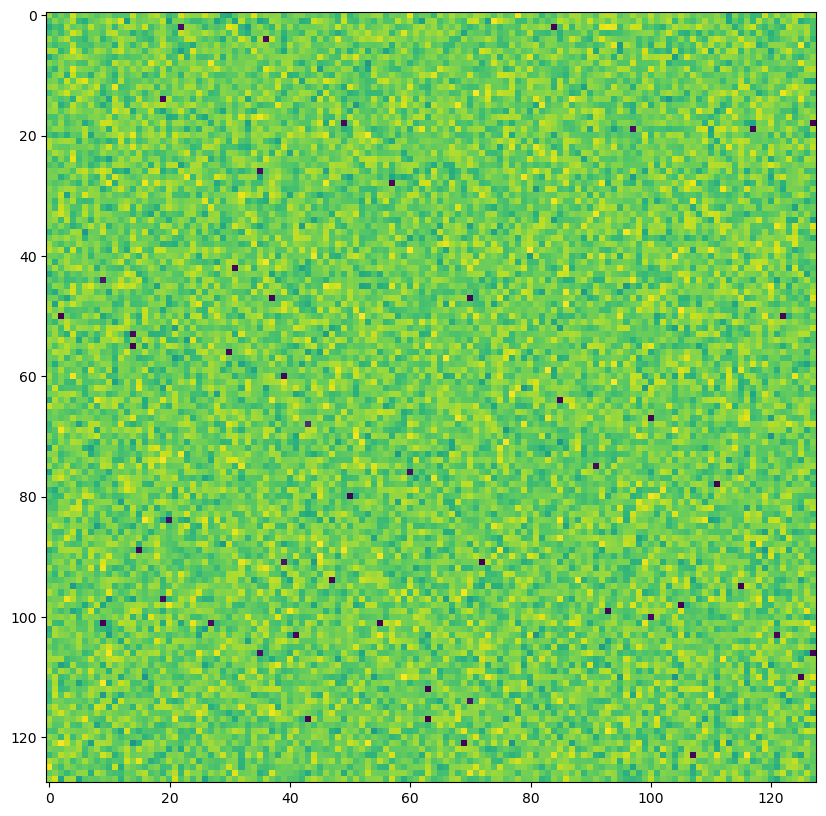

In [4]:
image, label = gen_random_binary_test_image(128, 128)
print('mean: {}'.format(np.mean(image)))
print('mask: {}'.format(np.max(label)))
plt.imshow(image.reshape((image.shape[0], image.shape[1])))

### Batch of data

Training is usually done using a batch of data. For semantic segmentation, that will be a batch of image (patches). We will also add the normalization of the data in this step. 

We will just scale the images in the range 0.0 to 1.0 from the full range of 0 to 255. Other possibilities are to scale the images individually according to their minimum and maximum values.

We will also convert the label images to a 1d Array to match the output of the network (we will see about that in the next step).


In [5]:
def gen_batch_binary(batch_size, height: int, width: int):
    image_list = []
    label_list = []
    for i in range(batch_size):
        img, label = gen_random_binary_test_image(height=height, width=width)
        image_list.append(img.astype(np.float32) / 255.0)
        label_list.append(label.astype(np.float32))

    image_batch = np.array(image_list, dtype=np.float32)
    label_batch = np.array(label_list, dtype=np.float32)

    # reshape labels as this is not done in the model
    label_batch = label_batch.reshape(batch_size, height,width, 1)

    return image_batch, label_batch

In [6]:
image_batch, label_batch = gen_batch_binary(100, 128, 128)
print(image_batch.shape)
print(label_batch.shape)

(100, 128, 128, 1)
(100, 128, 128, 1)


## Simple FCN

We will create a simple fully convolutional neural network for processing a batch of image patches

In [7]:
def fcn_simple_no_border(input_height:int, input_width:int) -> keras.Model:
    """
    Create a simple fcn model for semantic segmentation with 2 classes
    """
    model = keras.Sequential()
    
    # we use grayscale (1-channel input)
    
    # (used to define input shape on the first layers)
    model.add(keras.layers.Layer(input_shape=(input_height , input_width, 1)))
    
    # add 3 convolutional layers with 3x3 filters
    model.add(keras.layers.Convolution2D(filters=4, kernel_size=3, strides=(2, 2), padding='same', activation='relu'))
    model.add(keras.layers.Conv2DTranspose(filters=4, kernel_size=3, strides=(2, 2), padding='same', activation='relu'))
    model.add(keras.layers.Convolution2D(filters=4, kernel_size=3, padding='same', activation='relu'))
    
    # go to logits which is the number of classes and add sigmoid layer for activation
    model.add(keras.layers.Convolution2D(filters=1, kernel_size=1, activation=None, 
                                         kernel_initializer=keras.initializers.TruncatedNormal(mean=0.0, stddev=0.001, seed=None)))
    model.add(keras.layers.Activation('sigmoid'))
    
    # reshape so that we have a sample for each pixel
    model.add(keras.layers.Reshape(target_shape=(input_height, input_width, 1)))
    
    return model

In [8]:
model = fcn_simple_no_border(128, 128)

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer (Layer)               (None, 128, 128, 1)       0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 4)         40        
                                                                 
 conv2d_transpose (Conv2DTra  (None, 128, 128, 4)      148       
 nspose)                                                         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 4)       148       
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 1)       5         
                                                                 
 activation (Activation)     (None, 128, 128, 1)       0         
                                                        

In [10]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

Lets see if the model works....

In [11]:
history = model.fit(image_batch, label_batch, epochs=50, batch_size = 10, verbose=1)

Epoch 1/50
10/10 [==============================] - 1s 27ms/step - loss: 0.6930 - accuracy: 0.5066
Epoch 2/50
10/10 [==============================] - 0s 20ms/step - loss: 0.6921 - accuracy: 0.5400
Epoch 3/50
10/10 [==============================] - 0s 18ms/step - loss: 0.6909 - accuracy: 0.5400
Epoch 4/50
10/10 [==============================] - 0s 17ms/step - loss: 0.6886 - accuracy: 0.5400
Epoch 5/50
10/10 [==============================] - 0s 26ms/step - loss: 0.6851 - accuracy: 0.5400
Epoch 6/50
10/10 [==============================] - 0s 24ms/step - loss: 0.6800 - accuracy: 0.5400
Epoch 7/50
10/10 [==============================] - 0s 24ms/step - loss: 0.6737 - accuracy: 0.5400
Epoch 8/50
10/10 [==============================] - 0s 28ms/step - loss: 0.6657 - accuracy: 0.5400
Epoch 9/50
10/10 [==============================] - 0s 23ms/step - loss: 0.6584 - accuracy: 0.5400
Epoch 10/50
10/10 [==============================] - 0s 24ms/step - loss: 0.6513 - accuracy: 0.5400
Epoch 11/

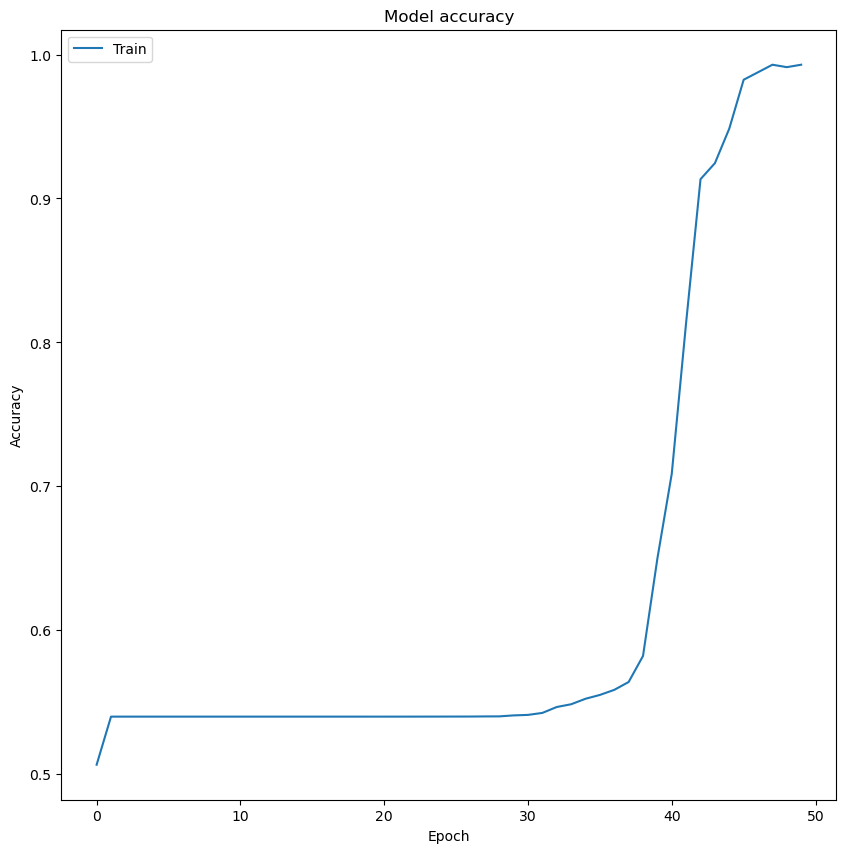

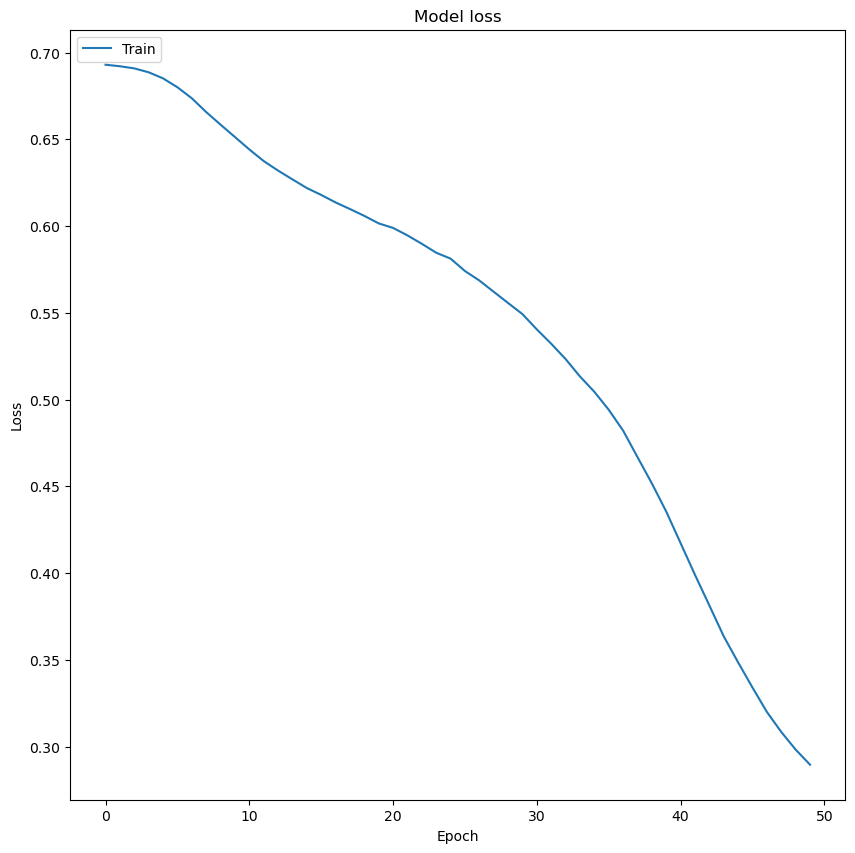

In [12]:
# Plot training accuracy values
plt.plot(history.history['accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

In [13]:
print('min, max, mean: {},{}, {}'.format(np.min(image_batch), np.max(image_batch), np.mean(image_batch)))

min, max, mean: 0.0,1.0, 0.6005670428276062


Predict a result

In [14]:
test_img, test_label = gen_random_binary_test_image(128,128)
print(f'label: {np.max(test_label)}')
print(f'mean: {np.mean(test_img)}')

label: 1
mean: 198.9755859375


In [15]:
img_batch = test_img[np.newaxis,:,:,:]
pred_img = model.predict(img_batch)
print(f'mean prob: {np.mean(pred_img)}')

1/1 [==============================] - 0s 96ms/step
mean prob: 1.0


In [16]:
pred_img.shape

(1, 128, 128, 1)

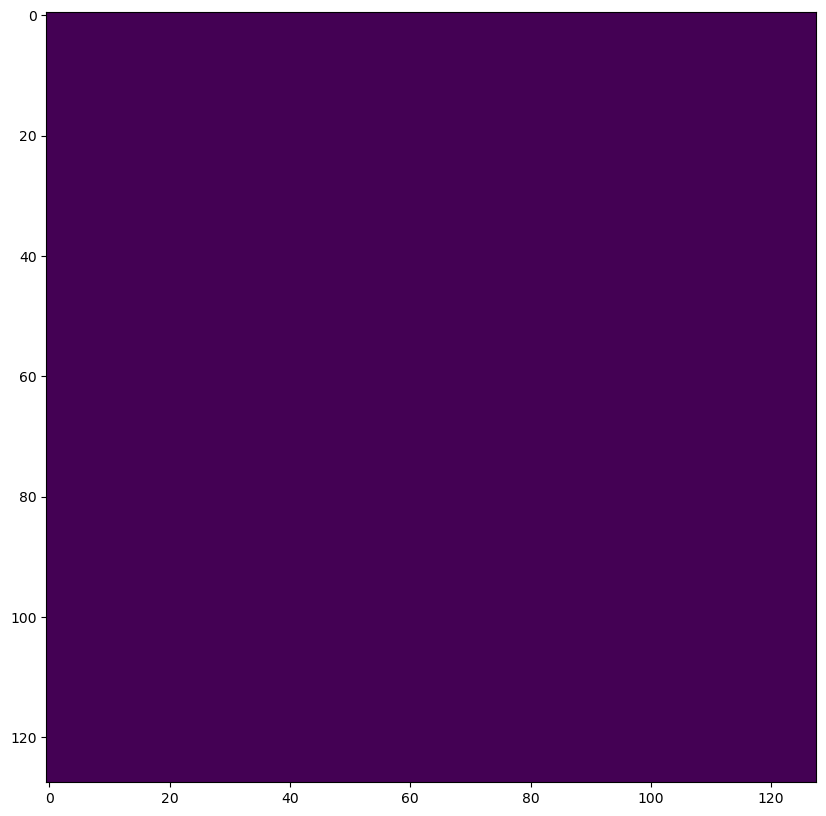

In [17]:
plt.imshow(pred_img[0,:,:,0])

## Training with generators

Reading the whole data set into memory is not always possible. There are different possibilities to that problem, one is to use the Dataset classes in the tensorflow backend. We will look at that a bit more in the next lecture. The other possibility is to use *generators* from python. A generator function to use for keras will generate a batch of data at the time. 

In [18]:
def batch_generator(batch_size, height: int, width: int):
    while True:
        image_batch, label_batch = gen_batch_binary(batch_size=batch_size, height=height, width=width)
        yield image_batch, label_batch

In order to use the generator, we use the ```model.fit_generator``` function. 

In [19]:
PATCH_HEIGHT = 128
PATCH_WIDTH = 128
BATCH_SIZE = 50
EPOCHS = 50
STEPS_PER_EPOCHS = 10
model = fcn_simple_no_border(PATCH_HEIGHT, PATCH_WIDTH)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit_generator(
        generator=batch_generator(BATCH_SIZE, PATCH_HEIGHT, PATCH_WIDTH),
        epochs=EPOCHS,
        verbose=1,
        steps_per_epoch=STEPS_PER_EPOCHS,
        shuffle=False,
        callbacks=None)

Epoch 1/50


/tmp/ipykernel_9427/150237172.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


10/10 [==============================] - 2s 110ms/step - loss: 0.6930 - accuracy: 0.5260
Epoch 2/50
10/10 [==============================] - 1s 110ms/step - loss: 0.6926 - accuracy: 0.5140
Epoch 3/50
10/10 [==============================] - 1s 98ms/step - loss: 0.6915 - accuracy: 0.7658
Epoch 4/50
10/10 [==============================] - 1s 106ms/step - loss: 0.6888 - accuracy: 0.5397
Epoch 5/50
10/10 [==============================] - 1s 102ms/step - loss: 0.6866 - accuracy: 0.4742
Epoch 6/50
10/10 [==============================] - 1s 111ms/step - loss: 0.6809 - accuracy: 0.4820
Epoch 7/50
10/10 [==============================] - 1s 98ms/step - loss: 0.6696 - accuracy: 0.5040
Epoch 8/50
10/10 [==============================] - 1s 107ms/step - loss: 0.6624 - accuracy: 0.4780
Epoch 9/50
10/10 [==============================] - 1s 99ms/step - loss: 0.6419 - accuracy: 0.5060
Epoch 10/50
10/10 [==============================] - 1s 106ms/step - loss: 0.6267 - accuracy: 0.5020
Epoch 11/50
1

## Exercise 1: Categorical data

In the example above we had only two classes, but in most applications we want to classify into more classes, as you have for example already done in the first homework, when classifying number.

Change the network and the generation of examples to use 5 classes.

In [20]:
# see solution below that uses both padding and categorical data


## Exercise 2: Padding

Also in the example, we used padding for the convolutional filters by specifying ```padding='same'```. However this will not process the data at the edges correctly as the missing data will be filled with 0. For training it is preferable to use only the data that fits inside the convolutional filters. This can be specified using ```padding='valid'```. However then the labels will have to be resized accordingly.

Change the network to use *valid* padding.

In [21]:
def fcn_simple_border(input_height:int, input_width:int, nr_classes:int) -> (keras.Model, int):
    """
    Create a simple fcn model for semantic segmentation with 2 classes.
    Return both the model and the border size
    """
    model = keras.Sequential()
    border = 0;
    
    # we use grayscale (1-channel input)
    
    # (used to define input shape on the first layers)
    model.add(keras.layers.Layer(input_shape=(input_height , input_width, 1)))
    
    # add 3 convolutional layers with 3x3 filters
    model.add(keras.layers.Convolution2D(filters=4, kernel_size=3, padding='valid', activation='relu'))
    border = border + 1
    model.add(keras.layers.Convolution2D(filters=8, kernel_size=3, padding='valid', activation='relu'))
    border = border + 1
    model.add(keras.layers.Convolution2D(filters=4, kernel_size=3, padding='valid', activation='relu'))
    border = border + 1
    
    # go to logits which is the number of classes and add softmax layer for activation
    model.add(keras.layers.Convolution2D(filters=nr_classes, kernel_size=1, activation=None, 
                                         kernel_initializer=keras.initializers.TruncatedNormal(mean=0.0, stddev=0.001, seed=None)))
    model.add(keras.layers.Activation('softmax'))
    
    # reshape so that we have a sample for each pixel
   
    return model, border


In [22]:
model, border = fcn_simple_border(128, 128, 5)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer_2 (Layer)             (None, 128, 128, 1)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 126, 126, 4)       40        
                                                                 
 conv2d_7 (Conv2D)           (None, 124, 124, 8)       296       
                                                                 
 conv2d_8 (Conv2D)           (None, 122, 122, 4)       292       
                                                                 
 conv2d_9 (Conv2D)           (None, 122, 122, 5)       25        
                                                                 
 activation_2 (Activation)   (None, 122, 122, 5)       0         
                                                                 
Total params: 653
Trainable params: 653
Non-trainable 

In [23]:
def gen_random_binary_test_image_classes(height: int, width: int, nr_classes)->(np.ndarray, np.ndarray):
    """
    Generate a test image and an appropriate label image with label 0 or label 1
    Label 0 images have a lower medium grayscale value, label 1 images a higher one.
    
    The returned images will have shape (height, width, 1) and type uint8 to be as compatible as possible to 
    mages read from files
    """
    class_id = np.random.choice(range(nr_classes))
    value = 255.0 * class_id / nr_classes 
    
    NOISE = 20.0
    
    label = np.zeros((height, width, 1), dtype=np.uint8)
    label.fill(class_id)
    img = np.random.normal(value, NOISE, ((height, width, 1))).astype(np.uint8)
    
    return img, label

def gen_batch_binary_with_border(batch_size, height: int, width: int, border: int, nr_classes:int):
    image_list = []
    label_list = []
    for i in range(batch_size):
        img, label = gen_random_binary_test_image_classes(height=height, width=width, nr_classes=nr_classes)
        label = label[border:-border, border:-border]
        image_list.append(img.astype(np.float32) / 255.0)
        label_list.append(label.astype(np.float32))

    image_batch = np.array(image_list, dtype=np.float32)
    label_batch = np.array(label_list, dtype=np.float32)

    # reshape labels as this is not done in the model
    # label_batch = label_batch.reshape(batch_size, (height-2*border)*(width-2*border), 1)
    label_batch = keras.utils.to_categorical(label_batch, num_classes=nr_classes)

    return image_batch, label_batch

def batch_generator_with_border(batch_size, height: int, width: int, border: int, nr_classes:int):
    while True:
        image_batch, label_batch = gen_batch_binary_with_border(batch_size=batch_size, 
                                                                height=height, width=width, 
                                                                border=border, nr_classes=nr_classes)
        yield image_batch, label_batch

In [24]:
PATCH_HEIGHT = 128
PATCH_WIDTH = 128
BATCH_SIZE = 128
EPOCHS = 4
STEPS_PER_EPOCHS = 100
NR_CLASSES = 5
model, border = fcn_simple_border(PATCH_HEIGHT, PATCH_WIDTH, NR_CLASSES)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(
        batch_generator_with_border(BATCH_SIZE, PATCH_HEIGHT, PATCH_WIDTH, border, NR_CLASSES),
        epochs=EPOCHS,
        verbose=1,
        steps_per_epoch=STEPS_PER_EPOCHS,
        shuffle=False,
        callbacks=None)

Epoch 1/4
100/100 [==============================] - 63s 622ms/step - loss: 1.5236 - accuracy: 0.2282
Epoch 2/4
100/100 [==============================] - 63s 634ms/step - loss: 0.9879 - accuracy: 0.4678
Epoch 3/4
100/100 [==============================] - 74s 739ms/step - loss: 0.4757 - accuracy: 0.8390
Epoch 4/4
100/100 [==============================] - 73s 725ms/step - loss: 0.3024 - accuracy: 0.9063


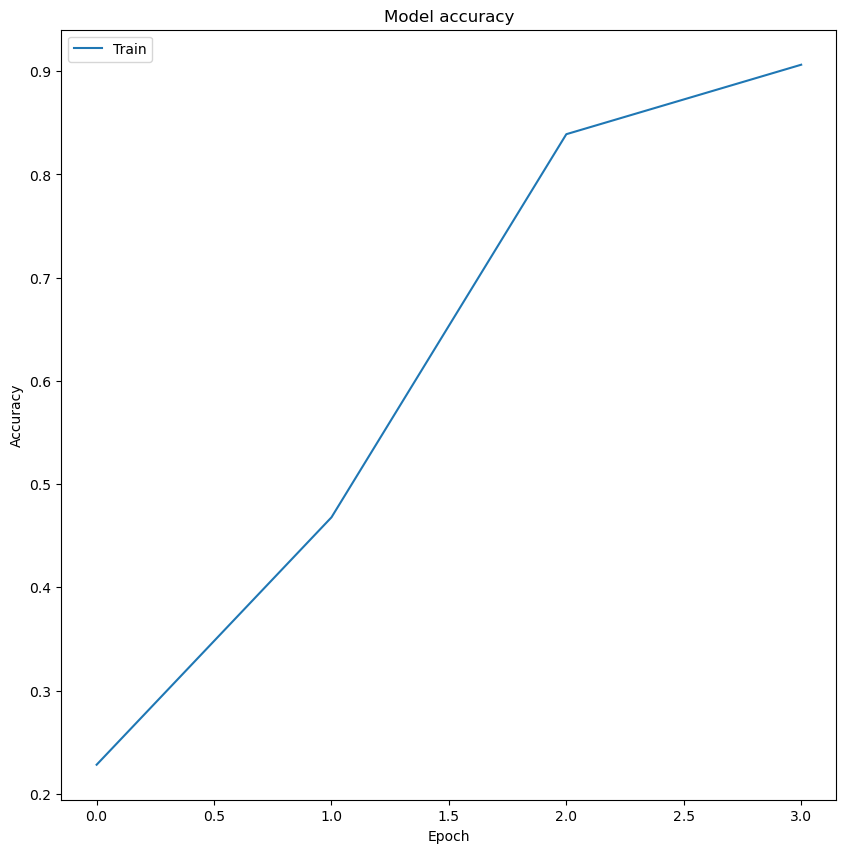

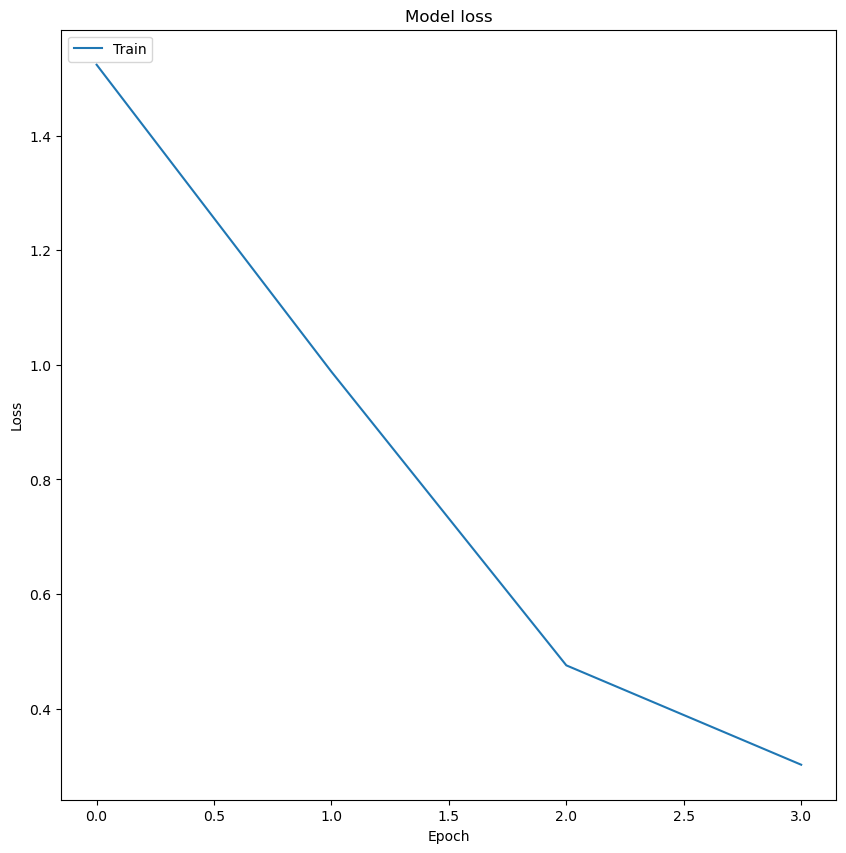

In [25]:
# Plot training accuracy values
plt.plot(history.history['accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

# Plot training loss values
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer_3 (Layer)             (None, 128, 128, 1)       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 126, 126, 4)       40        
                                                                 
 conv2d_11 (Conv2D)          (None, 124, 124, 8)       296       
                                                                 
 conv2d_12 (Conv2D)          (None, 122, 122, 4)       292       
                                                                 
 conv2d_13 (Conv2D)          (None, 122, 122, 5)       25        
                                                                 
 activation_3 (Activation)   (None, 122, 122, 5)       0         
                                                                 
Total params: 653
Trainable params: 653
Non-trainable 

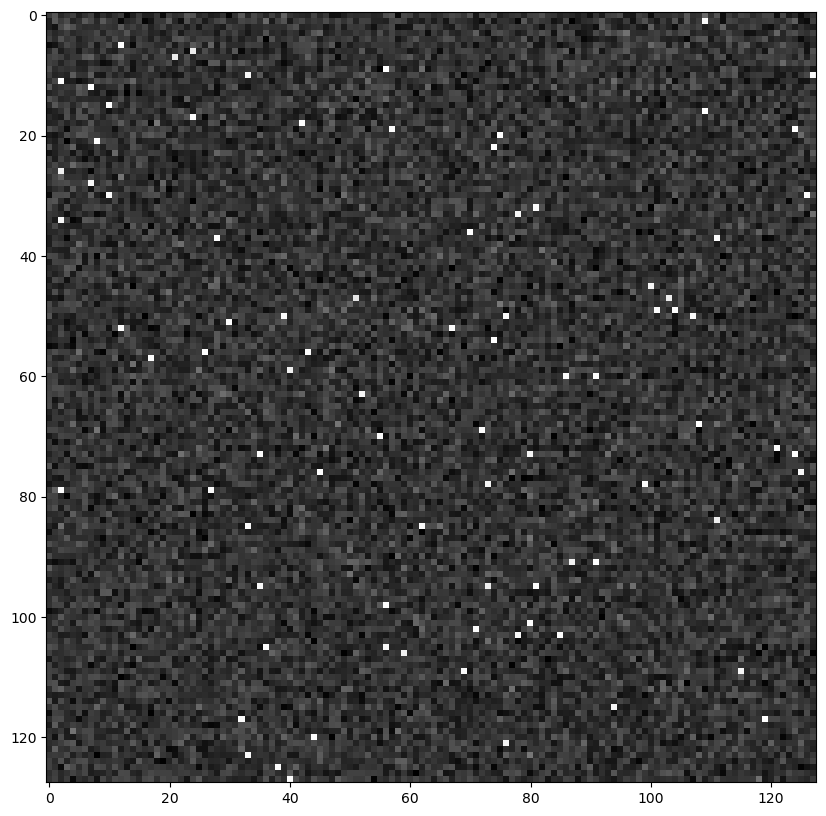

In [31]:
model.summary()
img, label = gen_random_binary_test_image_classes(128, 128, 5)
print(img.shape)
plt.imshow(img, cmap='gray', norm=matplotlib.colors.Normalize(0,255))
print(img.mean())
#img, label = batch_generator_with_border(1, 128, 128, border, 5)
print(f'Expected label: {np.mean(label)}')
batch_img = img[np.newaxis,:,:,:]
#pred_img = model(batch_img, training=False)
#for i in range (pred_img.shape[-1]):
#    print(f'Predicted label: {i}, mean prob: {np.mean(pred_img[0,:,:,i])}')
    

## Exercise 3: Data preparation for homework 2

In the homework, you should train a network to recognise different categories from the cityscapes data base for autonomous driving. A link to the data set is available in moodle, it is a small copy of the data where the images have been divided into smaller patches for easier processing. 

More information about the data set can be found here: https://www.cityscapes-dataset.com/

First, let us look at the label distribution in the training data. Load the label images and calculate a histogram of the labels.

Also find the maximal id that occurs in the label images.

In [33]:
from pathlib import Path
p = Path("/Users/toko/data/cityscape/train/")
pattern = 'train_lbl*.png'
label_files = list(p.glob(pattern))
first = True
r = list(range(257))
for file in label_files:
    label =  skimage.io.imread(file)
    if first:
        global_histogram, _ = np.histogram(label, bins=r)
        n_labels = 1
        first = False
        m = np.max(label)
    else:
        histogram, _ = np.histogram(label, bins=r)
        global_histogram += histogram
        m2 = np.max(label)
        m = max(m, m2)
        n_labels += 1
        
print(global_histogram / n_labels)
print(m)

NameError: name 'global_histogram' is not defined

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(np.arange(256),global_histogram)
plt.show()

Plot an image and its label image.

In [ ]:
selection = '002_11'
image_file = p / ('train_img_' + selection + '.png')
label_file = p / ('train_lbl_' + selection + '.png')

In [ ]:
image = skimage.io.imread(image_file)
label = skimage.io.imread(label_file)

In [ ]:
plt.subplot(1,2,1)
plt.imshow(image)
plt.subplot(1,2,2)
plt.imshow(label)

In [ ]:
print(label.shape)